In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Import Twitter Sentiment Dataset using API

In [3]:
!kaggle datasets download -d kazanova/sentiment140

 99% 80.0M/80.9M [00:00<00:00, 112MB/s] 
100% 80.9M/80.9M [00:00<00:00, 105MB/s]


In [4]:
#Extract the compressed dataset
from zipfile import ZipFile
ds = '/content/sentiment140.zip'

with ZipFile(ds, 'r') as zip:
  zip.extractall()
  print('We extracted the dataset')

We extracted the dataset


Import Dependencies

**1. Data Exploration**

In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#print stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Data Processing

In [8]:
#load data from csv to pandas dataframe
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [9]:
#Check the no of rows and colums
twitter_data.shape

(1599999, 6)

In [10]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
#naming the columns

col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names=col_names, encoding = 'ISO-8859-1')

In [12]:
#Check the no of rows and colums
twitter_data.shape

(1600000, 6)

In [13]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**2. Data Cleaning**

In [14]:
#missing values in dataset
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [15]:
#check the distribution of target column
twitter_data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Convert target '4' to '1'

In [16]:
twitter_data.replace({'target':{4:1}}, inplace = True)

In [17]:
#check the distribution of target column
twitter_data['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

0 --> Negative Tweet  
                      1 --> Positive Tweet

In [18]:
twitter_data.drop_duplicates(inplace=True)

In [19]:
twitter_data.drop(['id', 'flag', 'user'], axis=1, inplace=True)

**3. Exploratory Data Analysis (EDA)**

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

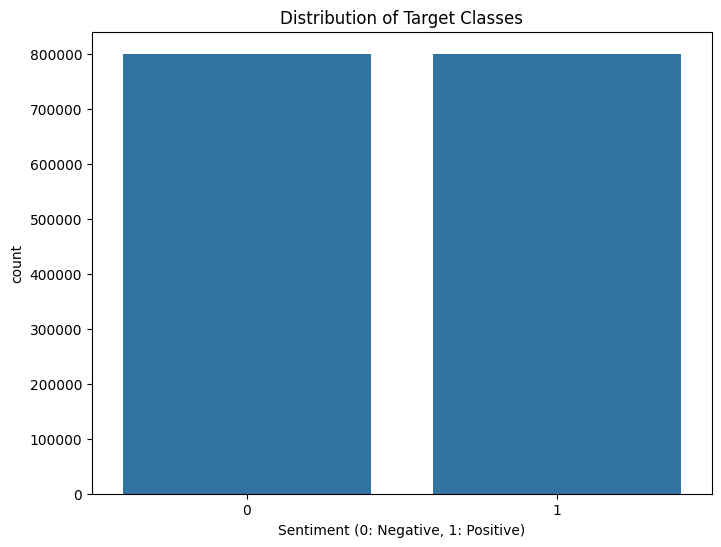

In [21]:
# Distribution of Target Classes
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=twitter_data)
plt.title('Distribution of Target Classes')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.show()

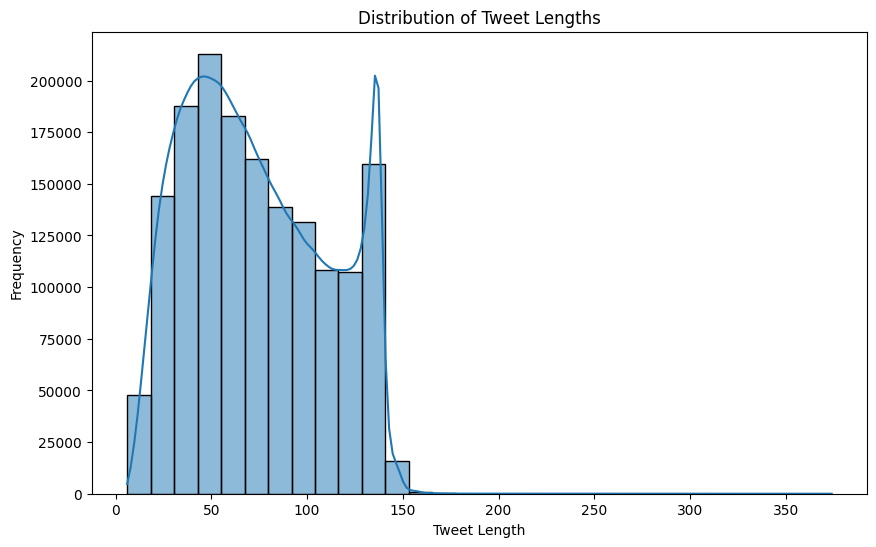

In [57]:
# Distribution of Tweet Lengths
twitter_data['tweet_length'] = twitter_data['text'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.histplot(twitter_data['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

In [58]:
# Word Cloud for Positive and Negative Tweets
from wordcloud import WordCloud

negative_tweets = twitter_data[twitter_data['target'] == 0]['text']
positive_tweets = twitter_data[twitter_data['target'] == 1]['text']


Word Cloud for Negative Tweets

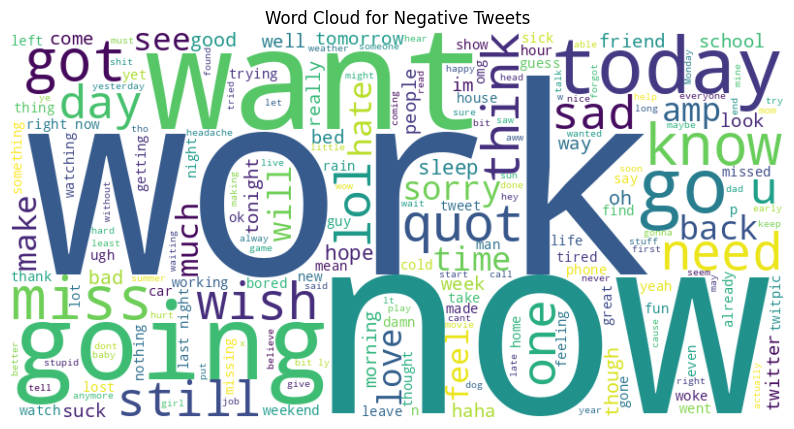

In [59]:
# Word Cloud for Negative Tweets
plt.figure(figsize=(10, 6))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweets))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Tweets')
plt.axis('off')
plt.show()

Word Cloud for Positive Tweets

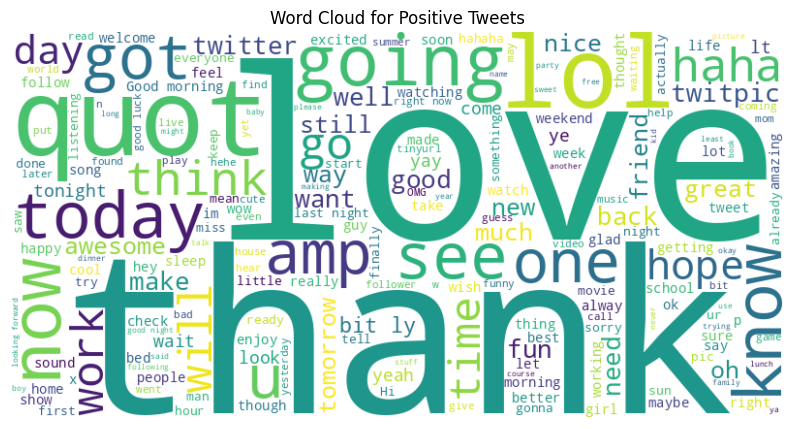

In [60]:
# Word Cloud for Positive Tweets
plt.figure(figsize=(10, 6))
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets')
plt.axis('off')
plt.show()

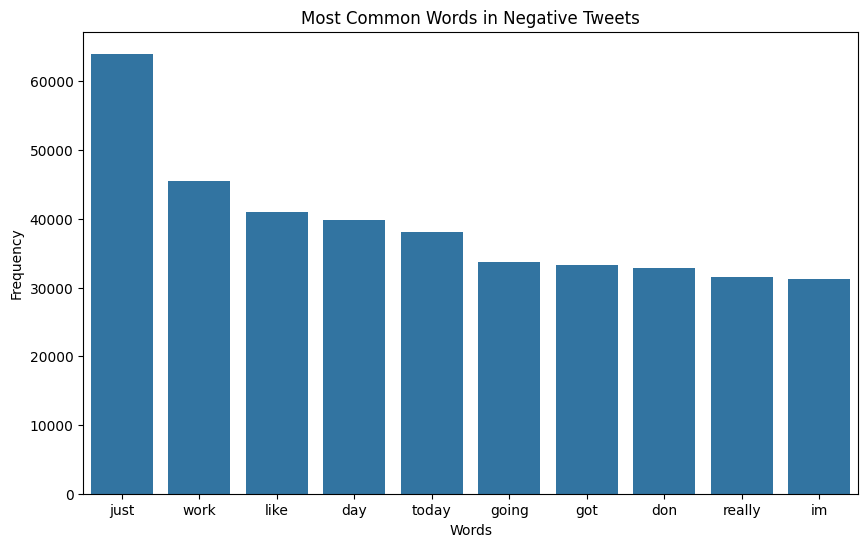

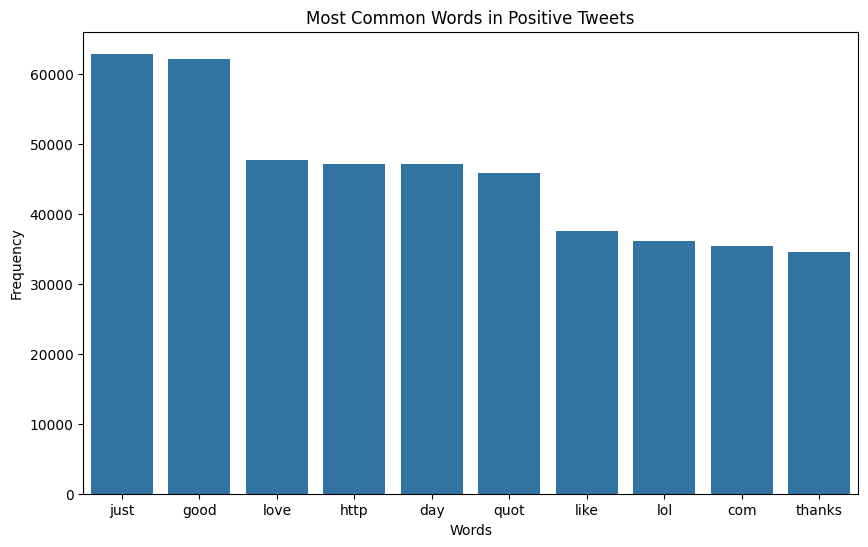

In [61]:
# Most Common Words in Positive and Negative Tweets
from sklearn.feature_extraction.text import CountVectorizer

def plot_most_common_words(tweets, title):
    vectorizer = CountVectorizer(stop_words='english')
    words = vectorizer.fit_transform(tweets)
    words_sum = words.sum(axis=0)
    words_freq = [(word, words_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[0] for word in words_freq], y=[word[1] for word in words_freq])
    plt.title(f'Most Common Words in {title} Tweets')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_most_common_words(negative_tweets, 'Negative')
plot_most_common_words(positive_tweets, 'Positive')

**4. Sentiment Distribution**

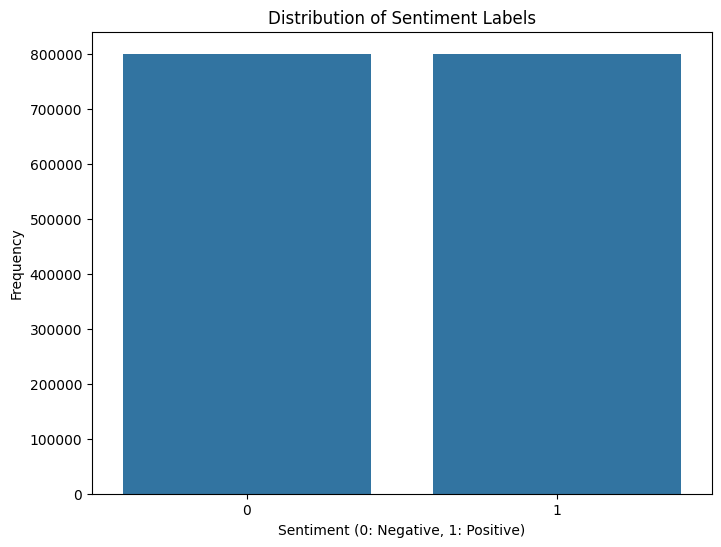

Sentiment Class Distribution:
0    800000
1    800000
Name: target, dtype: int64


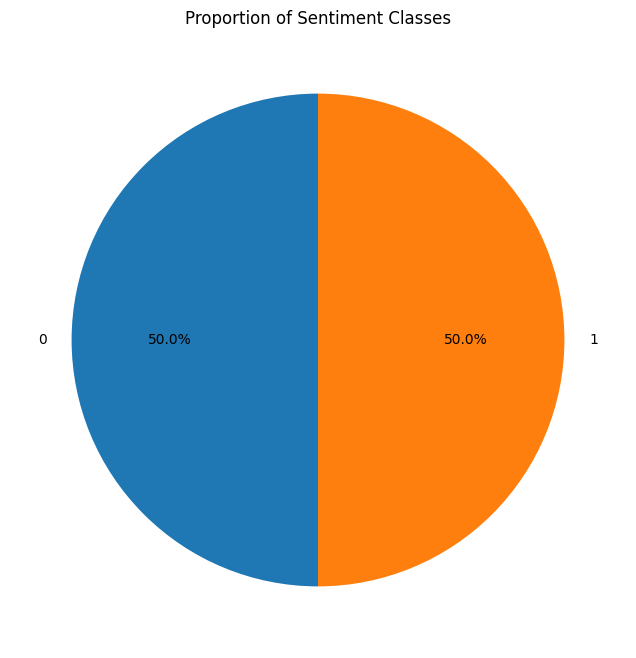

In [62]:
# Distribution of Sentiment Labels
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=twitter_data)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Frequency')
plt.show()

# Analyze the Balance of Sentiment Classes
sentiment_counts = twitter_data['target'].value_counts()

print("Sentiment Class Distribution:")
print(sentiment_counts)

# Pie chart to visualize the proportion of each sentiment class
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Sentiment Classes')
plt.show()


**6. Temporal Analysis**

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


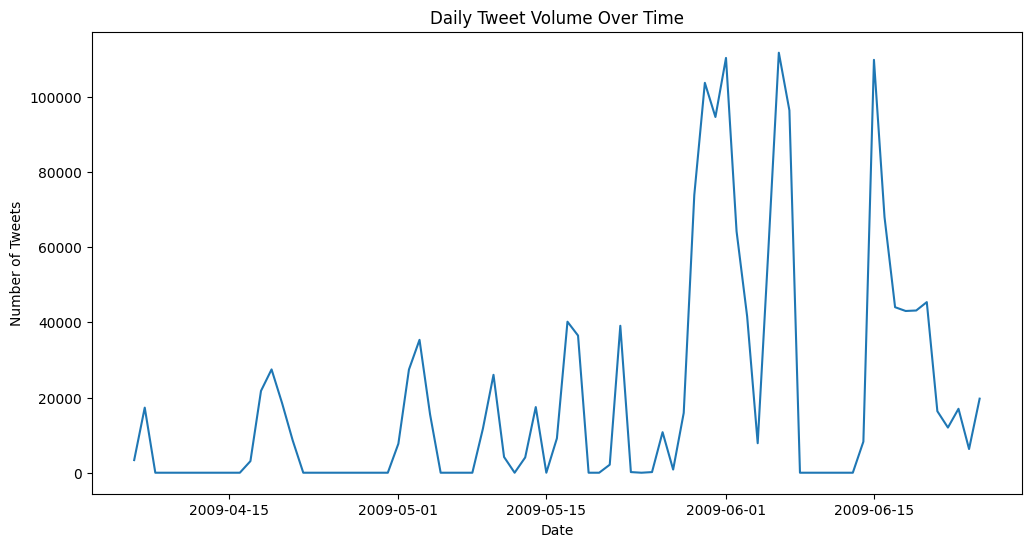

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

twitter_data['date'] = pd.to_datetime(twitter_data['date'])

# Set 'date' as the index for temporal analysis
twitter_data.set_index('date', inplace=True)

# Resample data to daily frequency and count the number of tweets per day
daily_tweets = twitter_data.resample('D').size()

# Plot temporal analysis
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_tweets.index, y=daily_tweets.values)
plt.title('Daily Tweet Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

**7. Text Preprocessing**

**Stemming**

Stemming is process of reducing the word to it's root word.

In [22]:
#stemming
port_stem = PorterStemmer()

In [23]:
def stemming(content):

  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

In [24]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [25]:
twitter_data.head()

,target,date,text,stemmed_content
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [26]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [27]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


**5. Word Frequency Analysis After Stemming**

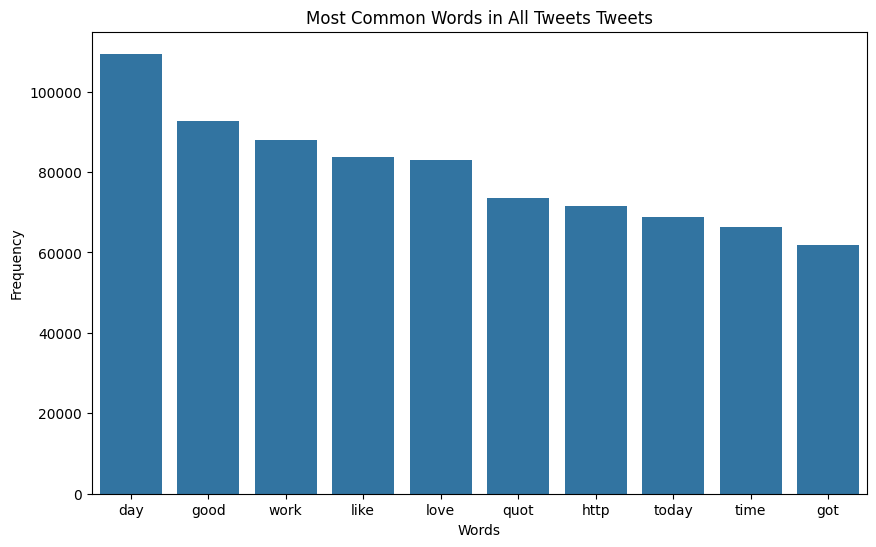

In [63]:
# Most Common Words in the Entire Dataset
plot_most_common_words(twitter_data['stemmed_content'], 'All Tweets')

Separating data and label

In [28]:
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [29]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [30]:
print(Y)

[0 0 0 ... 1 1 1]


Split the data into train and test data

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [33]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [34]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [35]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [36]:
#converting the textual data into numeric data
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
print(X_train)

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

In [38]:
print(X_test)

  (0, 420984)	0.17915624523539803
  (0, 409143)	0.31430470598079707
  (0, 398906)	0.3491043873264267
  (0, 388348)	0.21985076072061738
  (0, 279082)	0.1782518010910344
  (0, 271016)	0.4535662391658828
  (0, 171378)	0.2805816206356073
  (0, 138164)	0.23688292264071403
  (0, 132364)	0.25525488955578596
  (0, 106069)	0.3655545001090455
  (0, 67828)	0.26800375270827315
  (0, 31168)	0.16247724180521766
  (0, 15110)	0.1719352837797837
  (1, 366203)	0.24595562404108307
  (1, 348135)	0.4739279595416274
  (1, 256777)	0.28751585696559306
  (1, 217562)	0.40288153995289894
  (1, 145393)	0.575262969264869
  (1, 15110)	0.211037449588008
  (1, 6463)	0.30733520460524466
  (2, 400621)	0.4317732461913093
  (2, 256834)	0.2564939661498776
  (2, 183312)	0.5892069252021465
  (2, 89448)	0.36340369428387626
  (2, 34401)	0.37916255084357414
  :	:
  (319994, 123278)	0.4530341382559843
  (319995, 444934)	0.3211092817599261
  (319995, 420984)	0.22631428606830145
  (319995, 416257)	0.23816465111736276
  (319995, 3

**8. Sentiment Prediction Model**

Training the Machine Learning Model

Logistic Regression

In [39]:
model = LogisticRegression(max_iter=1000)

In [40]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Model Evaluation

Accuracy Score

In [41]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [42]:
print('Accuracy score on the training data is :', training_data_accuracy)

Accuracy score on the training data is : 0.81018984375


In [43]:
#Accuracy on Test Data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [44]:
print('Accuracy score on the test data is :', test_data_accuracy)

Accuracy score on the test data is : 0.7780375


**Model Accuracy is 77.8%**

Saving Trained Model

In [45]:
import pickle

In [46]:
filename = 'trained_model.pkl'
pickle.dump(model, open(filename, 'wb'))

**Using the saved model for Predictions**

In [47]:
#loading the saved model
loaded_model = pickle.load(open('/content/trained_model.pkl', 'rb'))

In [48]:
X_new = X_test[200]
print(Y_test[200])

prediction = loaded_model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('Negative Tweet')

else:
  print('Positive Tweet')

1
[1]
Positive Tweet


In [49]:
# Save both the model and the fitted vectorizer
with open('trained_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [55]:
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# Load the pre-trained model and vectorizer
loaded_model = pickle.load(open('/content/trained_model.pkl', 'rb'))
loaded_vectorizer = pickle.load(open('/content/vectorizer.pkl', 'rb'))

# Define Porter Stemmer
port_stem = PorterStemmer()

def preprocess_tweet(tweet, port_stem):

    stemmed_content = re.sub('[^a-zA-Z]',' ',tweet)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content

# Input a tweet for prediction
input_tweet = input("Enter a tweet for prediction: ")

# Preprocess the input tweet
processed_tweet = preprocess_tweet(input_tweet, port_stem)

# Vectorize the tweet using the pre-trained vectorizer
input_data = loaded_vectorizer.transform([processed_tweet])

# Make prediction using the loaded model
prediction = loaded_model.predict(input_data)

# Determine the sentiment
sentiment = 'Positive' if prediction[0] == 1 else 'Negative'

# Print the result
print(f"Input Tweet: {input_tweet}")
print(f"Predicted Sentiment: {sentiment}")


Enter a tweet for prediction: Thank You
Input Tweet: Thank You
Predicted Sentiment: Positive
